In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating project at `~/Downloads/cmu_classes/16745/final_project`


In [2]:
using LinearAlgebra
using ForwardDiff
using BlockDiagonals
using ControlSystems
using Plots

In [3]:
#Quaternion stuff
function hat(v)
    return [0 -v[3] v[2];
            v[3] 0 -v[1];
            -v[2] v[1] 0]
end
function L(q)
    s = q[1]
    v = q[2:4]
    L = [s    -v';
         v  s*I+hat(v)]
    return L
end
T = Diagonal([1; -ones(3)])
H = [zeros(1,3); I]
function qtoQ(q)
    return H'*T*L(q)*T*L(q)*H
end
function G(q)
    G = L(q)*H
end
function rptoq(ϕ)
    (1/sqrt(1+ϕ'*ϕ))*[1; ϕ]
end
function qtorp(q)
    q[2:4]/q[1]
end

qtorp (generic function with 1 method)

In [11]:
J = Diagonal([0.3, 0.3, 0.4])

h = 0.05 #20 Hz

Nx = 7     # number of states (quaternion)
Nx̃ = 6     # number of states (linearized)
Nu = 3     # number of controls
Tfinal = 10.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));

In [12]:
function E(q)
    E = BlockDiagonal([1.0*I(3), G(q)])
end

E (generic function with 1 method)

In [13]:
function quad_dynamics(x,u)
    ω = x[1:3]
    q = x[4:7]/norm(x[4:7]) #normalize q just to be careful
    Q = qtoQ(q)

    q_d = 0.5*L(q)*H*ω
    ω_d = J\(u - cross(ω, J * ω))
    
    return [ω_d; q_d;]
end

quad_dynamics (generic function with 1 method)

In [14]:
function quad_dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = quad_dynamics(x, u)
    f2 = quad_dynamics(x + 0.5*h*f1, u)
    f3 = quad_dynamics(x + 0.5*h*f2, u)
    f4 = quad_dynamics(x + h*f3, u)
    xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    xn[4:7] .= xn[4:7]/norm(xn[4:7]) #re-normalize quaternion
    return xn
end

quad_dynamics_rk4 (generic function with 1 method)

In [15]:
#Initial Conditions
uhover = [0.0, 0.0, 0.0]
ω0 = [0.0, 0.0, 0.0]
q0 = [1.0; 0; 0; 0]
x0 = [ω0; q0];

In [16]:
#Linearize dynamics about hover
A = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,uhover),x0)
B = ForwardDiff.jacobian(u->quad_dynamics_rk4(x0,u),uhover);

In [17]:
A

7×7 Matrix{Float64}:
 1.0    0.0    0.0    0.0  0.0  0.0  0.0
 0.0    1.0    0.0    0.0  0.0  0.0  0.0
 0.0    0.0    1.0    0.0  0.0  0.0  0.0
 0.0    0.0    0.0    0.0  0.0  0.0  0.0
 0.025  0.0    0.0    0.0  1.0  0.0  0.0
 0.0    0.025  0.0    0.0  0.0  1.0  0.0
 0.0    0.0    0.025  0.0  0.0  0.0  1.0

In [18]:
rank(A)#The naive A matrix will always be rank deficient due to the unit-norm constraint on the quaternion

6

In [19]:
#Controlability Matrix
C = B
for k = 1:(Nx-1)
    C = [C A*C[:,end-(Nu-1):end]]
end

In [20]:
rank(C) #The naive linearized system will always be uncontrollable

6

In [21]:
#Reduced system
Ã = Array(E(q0)'*A*E(q0))
B̃ = Array(E(q0)'*B);

In [22]:
#Controlability Matrix
C = B̃
for k = 1:(Nx-1)
    C = [C Ã*C[:,end-(Nu-1):end]]
end

In [23]:
rank(C) #Reduced system is controllable

6

In [24]:
# Cost weights
Q = Array(Diagonal([10, 10, 10, 1, 1, 1]));
R = Array(10*I(Nu));

In [25]:
#LQR Controller
K = dlqr(Ã,B̃,Q,R)

3×6 Matrix{Float64}:
  0.962852  -0.0       -0.0        0.28985  0.0      -0.0
 -0.0        0.962852  -0.0       -0.0      0.28985  -0.0
 -0.0       -0.0        0.997097  -0.0      0.0       0.295943

In [19]:
#Feedback controller
function controller(x)
    
    q0 = x0[4:7]
    q = x[4:7]
    ϕ = qtorp(L(q0)'*q)
    
    Δx̃ = [x[1:3]-ω0; ϕ]
    
    u = uhover - K*Δx̃
end

controller (generic function with 1 method)

In [20]:
u_low = -0.1
u_high = 0.1
u_range = 0.1

0.1

In [26]:
#Simulation
uhist = zeros(Nu,Nt)
xhist = zeros(Nx,Nt)
q_true = [0.01, -0.1, 0.1,0.5]
q_true /= norm(q_true)
xhist[:,1] = [[0.5, 0, 0]; q_true]
for k = 1:(Nt-1)
    uhist[:,k] = controller(xhist[:,k])
    u_scaled = uhist[:,k]
#     u_scaled /= norm(u_scaled)
#     u_scaled *= u_range
#     uhist[:,k] = u_scaled
    xhist[:,k+1] = quad_dynamics_rk4(xhist[:,k],u_scaled)
end

In [27]:
ω_hist = xhist[1:3, :]
q_hist = xhist[4:7, :]

4×201 Matrix{Float64}:
  0.0192414   0.0466264   0.105783  …   0.987798    0.987992    0.988182
 -0.192414   -0.188915   -0.18034      -0.0294003  -0.0291704  -0.0289422
  0.192414    0.205828    0.218431      0.0287272   0.0284979   0.0282704
  0.962072    0.959048    0.953192      0.150216    0.149028    0.14785

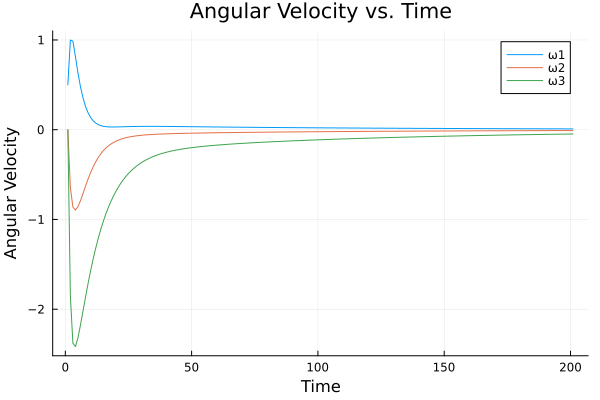

In [35]:
plot(ω_hist', labels=["ω1" "ω2" "ω3"], title="Angular Velocity vs. Time", xlabel="Time", ylabel="Angular Velocity")

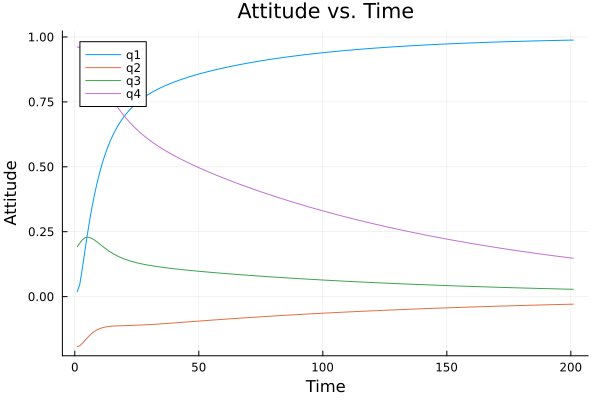

In [36]:
plot(q_hist', labels=["q1" "q2" "q3" "q4"], title="Attitude vs. Time", xlabel="Time", ylabel="Attitude")

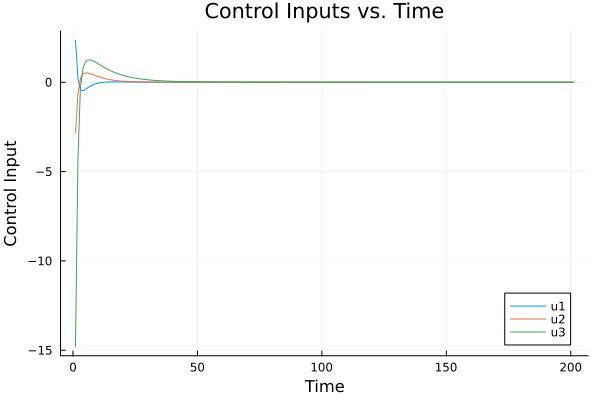

In [37]:
plot(uhist', labels=["u1" "u2" "u3"], title="Control Inputs vs. Time", xlabel="Time", ylabel="Control Input")